# WIP

## Pattern matching
### to answering "What do we know about COVID-19 risk factors?"

This notebook contains a pattern matching approach applied to the stated question above.

In [123]:
import numpy as np
import pandas as pd
import glob
import os
import json
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords as nltkstopwords
from nltk.tokenize import word_tokenize
import re
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, remove_stopwords, strip_multiple_whitespaces
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
base_path = "../input/CORD-19-research-challenge"

biorxiv_medrxiv = "biorxiv_medrxiv/biorxiv_medrxiv/pdf_json"
comm_use_subset = "comm_use_subset/comm_use_subset/pdf_json"
noncomm_use_subset = "noncomm_use_subset/noncomm_use_subset/pdf_json"
custom_license = "custom_license/custom_license/pdf_json"

In [125]:
files = []

def read_files(directory):
    files_in_dir = [f for f in glob.glob(os.path.join(base_path, directory) + "/*.json", recursive=True)]
    files.extend(files_in_dir)
    raw_body_texts_of_file = []
    for f in files_in_dir:
        data = json.load(open(f))
        #for key in data.keys():
        #    print("{}: {}\n".format(key, data[key]))
        
        body_text = ""
        for i in range(len(data["body_text"])):
            body_text += " " + data["body_text"][i]["text"]
        
        body_text = re.sub(' +', ' ', body_text)
        raw_body_texts_of_file.append(body_text)
    return raw_body_texts_of_file

raw_body_texts = []
raw_body_texts.extend(read_files(biorxiv_medrxiv))
raw_body_texts.extend(read_files(comm_use_subset))
#raw_body_texts.extend(read_files(noncomm_use_subset))
#raw_body_texts.extend(read_files(custom_license))

In [126]:
def print_title(idx):
    print(json.load(open(files[idx]))["metadata"]["title"])

def print_text(filenumber, start_idx, end_idx):
    text = raw_body_texts[filenumber]
    start_idx = max(0, start_idx)
    end_idx = min(len(text), end_idx)
    print(text[start_idx:end_idx])
    
def print_body_text(filenumber):
    data = json.load(open(files[filenumber]))
    body_text = ""
    for i in range(len(data["body_text"])):
        body_text += " " + data["body_text"][i]["text"]
    body_text = re.sub(' +', ' ', body_text)
    print(body_text)

In [127]:
print("Found {} raw body texts".format(len(raw_body_texts)))

Found 10707 raw body texts


In [128]:
NUMBER_OF_FILES = len(raw_body_texts)
WINDOW_SIZE = 200

### Search papers by regex patterns
The regex patterns contain on one hand words which might appear in context of risk factors and on the other hand some risk factors.

In [129]:
factor___risk_pattern = r"(factor(.){0,9}risk)" # for example for "factors of risk"
risk_factor_pattern = r"(risk(.){0,4}factor)" # for example risk factors
risk_pattern = r"(risk)"
high_risk_pattern = r"(high(.){0,6}risk)"
comorbdit_pattern = r"(comorbdit)"
co_infects_pattern = r"(co(.){0,4}infect)"
neonat_pattern = r"(neonat)"
pregnant_pattern = r"(pregnant)"
smoking_pattern = r"(smoking)"
cancer_pattern = r"(cancer)"
averse_outcomes_pattern = r"(advers(.){0,4}outcome)"

PATTERNS = [
    factor___risk_pattern,
    risk_factor_pattern,
    #risk_pattern,
    high_risk_pattern,
    #comorbdit_pattern,
    #co_infects_pattern,
    #neonat_pattern,
    #pregnant_pattern,
    #smoking_pattern,
    #cancer_pattern,
    averse_outcomes_pattern
]

CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation]
CUSTOM_FILTERS_EXCLUDE_NUMERIC = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric]

In [130]:
%%time
def extract_windows_containing(pattern, print_out=True):
    indices = []
    preprocessed_texts = []
    for idx in range(NUMBER_OF_FILES):
        filtered_sentence = raw_body_texts[idx]
        preprocessed_texts.append(filtered_sentence)
        
        indices_of_file = [(m.start(0), m.end(0)) for m in re.finditer(pattern, filtered_sentence)]
        indices.append(indices_of_file)
    
    return indices, preprocessed_texts


indices = [[] for _ in range(NUMBER_OF_FILES)]
for pattern in PATTERNS:
    indices_, preprocessed_texts = extract_windows_containing(pattern)
    for i in range(len(indices_)):
        indices[i].extend(indices_[i])

print("Found {} candidates".format(len([1 for a in indices if len(a)!=0])))

Found 2160 candidates
CPU times: user 2.77 s, sys: 1.13 ms, total: 2.77 s
Wall time: 2.78 s


Tokenize and remove stopwords

In [131]:
%%time
def process_file(file_number, indices_of_file, filters):
    tokenized_matches = []
    for match in indices_of_file:
        start = match[0]-WINDOW_SIZE
        end = match[1]+WINDOW_SIZE
        text = preprocessed_texts[file_number][start:end]
        tokenized = preprocess_string(text, filters)
        tokenized_matches.append(tokenized)

    return tokenized_matches

tokenized_data = []
for file_number, indices_of_file in enumerate(indices):
    if len(indices_of_file) != 0:
        for data in process_file(file_number, indices_of_file, CUSTOM_FILTERS_EXCLUDE_NUMERIC):
            for word in data:
                if len(word) > 2:
                    tokenized_data.append(word)

nltk_stop_words = set(nltkstopwords.words('english'))
for word in ["high", "risk", "factor", "patients", "factors", "disease"]:
    nltk_stop_words.add(word)
without_stopwords = [word for word in tokenized_data if word not in nltk_stop_words]
print("Number of words without stopwords: {}\n with stopwords {}".format(len(without_stopwords), len(tokenized_data)), end="\n\n")

Number of words without stopwords: 236676
 with stopwords 351442

CPU times: user 964 ms, sys: 3.69 ms, total: 968 ms
Wall time: 969 ms


#### Show words by count i.e. words which often appear in our current results

We can see some potential risk factors like  ('asthma', 2148) which means asthma appeared 2148 times in the context of potential words which indicates that a passage is about risk factors.
However just looking at context words is not so useful, but we can use it as an intermediate step to further look at potential risk factors indentfied here.

In [145]:
counts = Counter(without_stopwords)
print(counts.most_common(500))

[('infection', 1914), ('study', 1721), ('higher', 1332), ('associated', 1269), ('may', 1149), ('age', 1071), ('also', 1066), ('studies', 1047), ('influenza', 947), ('severe', 905), ('data', 844), ('cases', 820), ('health', 791), ('transmission', 772), ('virus', 762), ('analysis', 731), ('population', 730), ('infections', 722), ('mortality', 705), ('respiratory', 697), ('among', 690), ('children', 666), ('low', 661), ('however', 647), ('clinical', 609), ('group', 608), ('reported', 597), ('identified', 590), ('one', 579), ('used', 560), ('years', 552), ('significant', 545), ('individuals', 545), ('viral', 536), ('diseases', 536), ('results', 523), ('could', 523), ('potential', 521), ('found', 518), ('human', 515), ('control', 512), ('groups', 511), ('table', 510), ('viruses', 497), ('exposure', 496), ('countries', 493), ('important', 485), ('infected', 483), ('case', 479), ('including', 478), ('number', 477), ('two', 475), ('treatment', 474), ('use', 473), ('model', 467), ('hospital', 4

Visualization of the top words in a word cloud

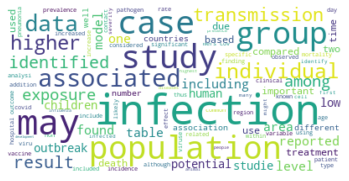

In [133]:
text = " ".join(without_stopwords)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Search potential passages for given potential risks

Now we are going through the preprocessed data and look for possible risks, which we collected through our knowledge and the experiment above.

We print the file number, the index where the inital match of the experiment above happens and an extract of the body text.

Because some patterns might match for the same window/extract of text we adjust the index to contain a bigger window to avoid intersecting text windows.

In [134]:
POTENTIAL_RISKS = [
    "smoking",
    "pulmonary diseas", 
    "elder",
    "diabetes",
    "old",
    "age",
    "cancer", 
    "cardiac",
    "cardio"]

In [135]:
def doit(only_directly_related_files=False):
    print_counter = 0
    overall_processed_indices_count = 0
    for file_number, indices_of_file in enumerate(indices):
        if only_directly_related_files and file_number in not_directly_related_files:
            continue
        if len(indices_of_file) != 0:
            matches = process_file(file_number, indices_of_file, CUSTOM_FILTERS)
            processed_indices_of_file = []
            indices_of_file = sorted(indices_of_file)
            # adjust indices
            for i in range(len(indices_of_file)):
                if i != 0 and len(processed_indices_of_file) != 0:
                    if abs(processed_indices_of_file[-1][0] - indices_of_file[i][0]) > 100 and abs(processed_indices_of_file[-1][1] - indices_of_file[i][1]) > 100:
                        processed_indices_of_file.append(indices_of_file[i])
                    else:
                        min_ = min(indices_of_file[i][0], processed_indices_of_file[-1][0])
                        max_ = max(indices_of_file[i][1], processed_indices_of_file[-1][1])
                        del processed_indices_of_file[-1]
                        processed_indices_of_file.append((min_, max_))
                else:
                    processed_indices_of_file.append(indices_of_file[i])
            overall_processed_indices_count += len(processed_indices_of_file)

            for index, match in zip(processed_indices_of_file, matches):
                for pattern in POTENTIAL_RISKS:
                    if pattern in match:
                        windows_size = max(int(len(" ".join(match))/2), 300)
                        if print_counter < 50:
                            print("File number: {} index pair: {}".format(file_number, index))
                            print_text(file_number, index[0]-windows_size, index[1]+windows_size)
                            print("\n\n")
                            print_counter += 1
                        break
    return overall_processed_indices_count

overall_processed_indices_count = doit()

File number: 12 index pair: (3896, 3907)
cal authority, is essential 245 for emergency management. outbreak control. The study also found that uptake of prevention practices was poorer among older 247 members of the public, which warrants serious attention. It has been found that older 248 adults affected by 2019-nCoV are likely to have a higher risk of complications and 249 mortality (4). There is a need to find out whether a lack of appropriate prevention 250 practices among people of older age is due to knowledge deficiency or to their being 251 out-of-reach of current public health intervention. The finding that nearly 15% of people would b



File number: 15 index pair: (7902, 7918)
s associated with inferior outcome 6 . Interestingly, . CC-BY-NC-ND 4.0 International license It is made available under a is the author/funder, who has granted medRxiv a license to display the preprint in perpetuity. Given that Case 2 has a history of long-term use of glucocorticoids, which is the hig

In [136]:
print("Total number of possible text passages about risk factors: {}".format(overall_processed_indices_count))

Total number of possible text passages about risk factors: 6796


In total we found many possible text passages, where some are really about risk factors of covid 19 and others are not.

An example of a useful text extract is:
"""
File number: 60 index pair: (12790, 12801)
the . https://doi.org/10.1101/2020.03.21.001586 doi: bioRxiv preprint Clinical investigations have suggested that patients with cardiac diseases, hypertension, or diabetes, who are treated with ACE2-increasing drugs including inhibitors and blockers show increased expression of ACE2 and thus are at higher risk of getting the SARS-CoV2 infection (26) . Also there are studies on the regulatory role of miRNA hsa-mir-27b-3p described in ACE2 Signaling (27) . The results of the present study suggest a strong correlation between miRNA hsa-mir-27b-3p and ACE2 which needs to be confirmed experimentally in SARS-C
"""

And one example of a bad extract with respect to risk factors is:
"""
File number: 239 index pair: (199, 203)
 Severe cases of coronavirus disease 2019 (COVID-19) rapidly develop acute respiratory distress leading to respiratory failure, with high short-term mortality rates. At present, there is no reliable risk stratification tool for non-severe COVID-19 patients at admission. We aimed to construct an effective model for early identifying cases at high risk of progression to severe COVID-19. China were included retrospectively. All patients with non-severe COVID-19 during hospitalization were followed for
"""


If we want to print more context for a given filenumber we can use the code in the next cell.

##### Show an extract based on start and end index for a file number

In [137]:
file_number = 239
start_idx = 0
end_idx = 2000

print_text(file_number, start_idx, end_idx)

 COVID-19, the disease caused by SARS-CoV-2 virus that surfaced in Wuhan, China in early December 2019, is now plaguing the world. Due to its high intra-human transmission nature, there were more than one hundred and fifty thousand confirmed cases around the world by 15 March, 2020 . In view of the rapid surge of infected patients, World Health Organization (WHO) has declared the viral disease a pandemic on 11 March, 2020. To contain COVID-19, a prompt and accurate diagnostic test is necessary. While new tests have been proposed, the SARS-CoV-2 nucleic acid test is currently the standard diagnostic criterion used by most countries. However, contradictory to clinical symptoms and chest CT scanning, many patients have shown false negative testing results during their initial clinic visits. As a result, hospital admission and treatment have been delayed for many of them. These patients have been stranded in outpatient clinics or isolation zones, increasing the risk of exposure of other no

One drawback of this approach applied to the given data is the occurrence of false positives, this means our patterns match for passages which might be irrelevant.
This can for example happen when a document is not about covid 19 and hence the passage doesn't mention risk factors for covid 19. Maybe a document is about another virus, which is more or less similar to Covid 19, which makes it hard to judge if the paper is relevant.
Below we are looking for files which might not directly relate to Covid-19

In [138]:
def is_file_directly_related(filenumber):
    data = json.load(open(files[filenumber]))
    synonyms_for_covid_19 = [
        r"(covid)",
        r"(sars)",
        r"(cov(.){0,4}2)",
        r"(novo)",
        r"(corona)",
    ]
    body_text = ""
    for i in range(len(data["body_text"])):
        body_text += " " + data["body_text"][i]["text"].lower()
    body_text = re.sub(' +', ' ', body_text)
    
    at_least_one_match = False
    for synonym_pattern in synonyms_for_covid_19:
        matches = [(m.start(0), m.end(0)) for m in re.finditer(synonym_pattern, body_text)]
        if len(matches) != 0:
            return True
    return False

not_directly_related_files = []
for i in range(len(files)):
    if not is_file_directly_related(i):
        not_directly_related_files.append(i)
print("Found {} files which might not directly relate to Covid-19".format(len(not_directly_related_files)))

Found 3558 files which might not directly relate to Covid-19


### To investigate some of the potentially not directly related papers we can print their title and body text.

In [139]:
print_title(not_directly_related_files[1])

Restriction Factor in Yeasts 2 3


In [140]:
print_body_text(not_directly_related_files[1])

 To differentiate between models where Xrn1p restricts L-A through a passive 158 mechanism that is incidental to its inherant exonuclease activity, or through an active 159 mechanism where Xrn1p evolves to optimally suppress L-A replication, we first looked 160 for evidence of positive selection (dN/dS > 1) within the genes encoding the major 161 components of the SKI complex, the exosome, and Xrn1p ( Fig 1B) . Importantly, cerevisiae, S. paradoxus, S. mikatae, S. kudriavzevii, S. arboricolus, and S. bayanus) 171 [44] [45] [46] and created a multiple sequence alignment. We then analyzed each alignment 172 for evidence of codons with dN/dS > 1 using four commonly employed tests for positive 173 selection [47, 48] . We see some evidence for positive selection of specific codon sites in 174 several of these genes, however, only XRN1 and the exosome subunit gene RRP40 175 passed all four tests ( Fig 1C; Table S1 ). Other genes are determined to be under surprising for a critical and conser

In [141]:
overall_processed_indices_count = doit(only_directly_related_files=True)

File number: 12 index pair: (3896, 3907)
cal authority, is essential 245 for emergency management. outbreak control. The study also found that uptake of prevention practices was poorer among older 247 members of the public, which warrants serious attention. It has been found that older 248 adults affected by 2019-nCoV are likely to have a higher risk of complications and 249 mortality (4). There is a need to find out whether a lack of appropriate prevention 250 practices among people of older age is due to knowledge deficiency or to their being 251 out-of-reach of current public health intervention. The finding that nearly 15% of people would b



File number: 15 index pair: (7902, 7918)
s associated with inferior outcome 6 . Interestingly, . CC-BY-NC-ND 4.0 International license It is made available under a is the author/funder, who has granted medRxiv a license to display the preprint in perpetuity. Given that Case 2 has a history of long-term use of glucocorticoids, which is the hig

In [142]:
print("Total number of possible text passages about risk factors: {}".format(overall_processed_indices_count))

Total number of possible text passages about risk factors: 4830


Another problem is, even if a paper at least contains the word "coronavirus" doesn't mean it is about it.
For example one paper only lists coronavirus as a coinfection, hence the risk factors in it are not about the coronavirus but are detected as potential risk factors by this pattern matching approach.

In [143]:
#print_title(8238)

In [144]:
#print_body_text(8238)